In [23]:
#
# GRIB2 GSM FAX天気図　FXFE5782 / FXFE5784の　700hPa湿数、500hPa気温予想図
#   2021/12/02 R.Kurora
#
import math
import pygrib
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib.path as mpath
import cartopy.crs as ccrs
import datetime
import sys
#
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage.filters import maximum_filter, minimum_filter
#
import argparse

In [24]:
## 緯度経度で指定したポイントの図上の座標などを取得する関数 transform_lonlat_to_figure() 
# 図法の座標 => pixel座標 => 図の座標　と3回の変換を行う
#  　pixel座標: plt.figureで指定した大きさxDPIに合わせ、左下を原点とするpixelで測った座標   
#  　図の座標: axesで指定した範囲を(0,1)x(0,1)とする座標
# 3つの座標を出力する
#    図の座標, Pixel座標, 図法の座標
def transform_lonlat_to_figure(lonlat, ax, proj):
    # lonlat:経度と緯度  (lon, lat) 
    # ax: Axes図の座標系    ex. fig.add_subplot()の戻り値
    # proj: axで指定した図法 
    #
    # 例 緯度経度をpointで与え、ステレオ図法る場合
    #    point = (140.0,35.0)
    #    proj= ccrs.Stereographic(central_latitude=60, central_longitude=140) 
    #    fig = plt.figure(figsize=(20,16))
    #    ax = fig.add_subplot(1, 1, 1, projection=proj)
    #    ax.set_extent([108, 156, 17, 55], ccrs.PlateCarree())
    #
    ## 図法の変換
    # 参照  https://scitools.org.uk/cartopy/docs/v0.14/crs/index.html                    
    point_proj = proj.transform_point(*lonlat, ccrs.PlateCarree())
    #
    # pixel座標へ変換
    # 参照　https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html
    point_pix = ax.transData.transform(point_proj)
    #
    # 図の座標へ変換                                                           
    point_fig = ax.transAxes.inverted().transform(point_pix)
    return point_fig, point_pix, point_proj

In [25]:
## 極大/極小ピーク検出関数                                                             
def detect_peaks(image, filter_size=3, dist_cut=5.0, flag=0):
    # filter_size: この値xこの値 の範囲内の最大値のピークを検出                        
    # dist_cut: この距離内のピークは1つにまとめる                                      
    # flag:  0:maximum検出  0以外:minimum検出                                          
    if flag==0:
      local_max = maximum_filter(image,
            footprint=np.ones((filter_size, filter_size)), mode='constant')
      detected_peaks = np.ma.array(image, mask=~(image == local_max))
    else:
      local_min = minimum_filter(image,
            footprint=np.ones((filter_size, filter_size)), mode='constant')
      detected_peaks = np.ma.array(image, mask=~(image == local_min))
    peaks_index = np.where((detected_peaks.mask != True))
    # peak間の距離行例を求める                                                         
    (x,y) = peaks_index
    size=y.size
    dist=np.full((y.size, y.size), -1.0)
    for i in range(size):
      for j in range(size):
        if i == j:
          dist[i][j]=0.0
        elif i>j:
          d = math.sqrt(((y[i] - y[j])*(y[i] - y[j]))
                        +((x[i] - x[j])*(x[i] - x[j])))
          dist[i][j]= d
          dist[j][i]= d
    # 距離がdist_cut内のpeaksの距離の和と、そのピーク番号を取得する 
    Kinrin=[]
    dSum=[]
    for i in range(size):
      tmpA=[]
      distSum=0.0
      for j in range(size):
        if dist[i][j] < dist_cut and dist[i][j] > 0.0:
          tmpA.append(j)
          distSum=distSum+dist[i][j]
      dSum.append(distSum)
      Kinrin.append(tmpA)
    # Peakから外すPeak番号を求める.  peak間の距離和が最も小さいものを残す              
    cutPoint=[]
    for i in range(size):
      val = dSum[i]
      val_i=image[x[i]][y[i]]
      for k in Kinrin[i]:
        val_k=image[x[k]][y[k]]
        if flag==0 and val_i < val_k:
            cutPoint.append(i)
            break
        if flag!=0 and val_i > val_k:
            cutPoint.append(i)
            break
        if val > dSum[k]:
            cutPoint.append(i)
            break
        if val == dSum[k] and i > k:
            cutPoint.append(i)
            break
    # 戻り値用に外すpeak番号を配列から削除                                             
    newx=[]
    newy=[]
    for i in range(size):
      if (i in cutPoint):
        continue
      newx.append(x[i])
      newy.append(y[i])
    peaks_index=(np.array(newx),np.array(newy))
    return peaks_index

In [26]:
# GSMの読み込む初期値の年月日時をUTCで与えます。
i_year =2021
i_month = 8
i_day = 23
i_hourZ = 0
#
# 予想時間を与える。この値は注意が必要です。下3桁目が日数、下２桁で時間で与えます。
#  初期値なら0、18時間後なら18、24時間後なら100、36時間後なら112となります。
i_ft = 0
#
# 読み込む気圧面の気圧
tagTmp=500
tagTTd=700
#
## GPVの切り出し領域の指定：(lonW,latS)-(lonE,latN)の矩形                                                                                                      
latS=-20
latN=80
lonW=70
lonE=190
#
# データの格納先フォルダー名
##!!! GRIB2データの保存先をFolderを指定すること !!!
data_fld="./data/gsm/"
#
## 描画指定
# 地図の描画範囲指定
#i_area = [115, 151, 20, 50]  # 日本付近
i_area = [108, 156, 17, 55]   # FEAX
#i_area = [105, 180,  0, 65]   # ASAS
# 緯線・経線の指定
dlon,dlat=10,10   # 10度ごとに
## 気温　等値線
levels_tmp =np.arange(-60,30,3)
## 露点差 ハッチ 
levels_h_ttd=[0, 3, 6, 18, 100]
levels_h_ttd_col=['green','0.9','1.0','yellow']
## 露点差 等値線
levels_ttd=np.arange(3,30,3)

In [27]:
####################################################
#
# 読み込むGRIB2形式GSMのファイル名
gsm_fn_t="Z__C_RJTD_{0:4d}{1:02d}{2:02d}{3:02d}0000_GSM_GPV_Rgl_FD{4:04d}_grib2.bin"
gr_fn= gsm_fn_t.format(i_year,i_month,i_day,i_hourZ,i_ft)
#
# データOpen
grbs = pygrib.open(data_fld + gr_fn)
#
# データ取得                                                                                                                   
grbTm500 = grbs(shortName="t",typeOfLevel='isobaricInhPa',level=tagTmp)[0]
grbTm700 = grbs(shortName="t",typeOfLevel='isobaricInhPa',level=tagTTd)[0]
grbRh700 = grbs(shortName="r",typeOfLevel='isobaricInhPa',level=tagTTd)[0]
#
# データClose
grbs.close()
#
print(gr_fn)
#
## データ切り出し                                                                                                                   
valT5, latT5, lonT5 = grbTm500.data(lat1=latS,lat2=latN,lon1=lonW,lon2=lonE)
valT7, latT7, lonT7 = grbTm700.data(lat1=latS,lat2=latN,lon1=lonW,lon2=lonE)
valR7, latR7, lonR7 = grbRh700.data(lat1=latS,lat2=latN,lon1=lonW,lon2=lonE)

Z__C_RJTD_20210823000000_GSM_GPV_Rgl_FD0000_grib2.bin


In [28]:
## Tを表示するための、xarrayデータセットを作成                                                                                   
dst = xr.Dataset(
    {
        "temperature": (["lat", "lon"],valT5 * units('K')),
    },
    coords={
        "level": [tagTmp],
        "lat": latT5[:,0],
        "lon": lonT5[0,:],
        "time": [grbTm500.validDate],
    },
)
# 単位
dst['temperature'].attrs['units'] = 'K'
dst['level'].attrs['units'] = 'hPa'
dst['lat'].attrs['units'] = 'degrees_north'
dst['lon'].attrs['units'] = 'degrees_east'
#
dstp= dst.metpy.parse_cf()

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [29]:
## T-Tdを算出されるための、xarrayデータセットを作成                                                                                   
ds = xr.Dataset(
    {
        "temperature": (["lat", "lon"],valT7 * units('K')),
        "relative_humidity": (["lat", "lon"],valR7 * units('%')),
    },
    coords={
        "level": [tagTTd],
        "lat": latT7[:,0],
        "lon": lonT7[0,:],
        "time": [grbTm700.validDate],
    },
)
# 単位
ds['temperature'].attrs['units'] = 'K'
ds['relative_humidity'].attrs['units']='%'
ds['level'].attrs['units'] = 'hPa'
ds['lat'].attrs['units'] = 'degrees_north'
ds['lon'].attrs['units'] = 'degrees_east'
#
## T-Tdの算出                                                                                                                                           
ds['ttd'] = ds['temperature'] - mpcalc.dewpoint_from_relative_humidity(ds['temperature'],ds['relative_humidity'])
ds['ttd'].attrs['units']='K'
#
dsp= ds.metpy.parse_cf()

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [30]:
## タイトル文字列用
# 予想時間を得る
ft_hours=int(i_ft/100) * 24 + int(i_ft%100)
# 初期時刻の文字列
dt_i = grbTm500.analDate
dt_str = (dt_i.strftime("%H00UTC%d%b%Y")).upper()
dt_str2 = dt_i.strftime("%Y%m%d%H")

In [31]:
lat0 = dstp['lat'].values
lon0 = dstp['lon'].values

/Users/rkurora/opt/anaconda3/envs/met_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


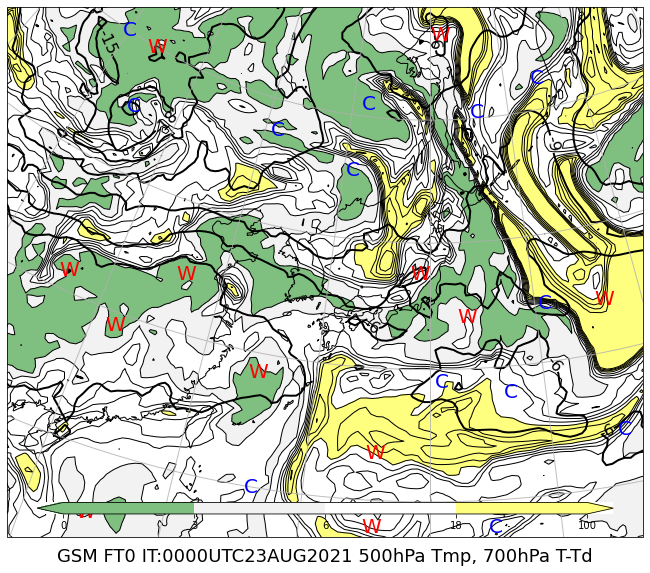

In [32]:
## 図のSIZE指定inch                                                              
fig = plt.figure(figsize=(10,8))                                          
## 余白設定                                                                      
plt.subplots_adjust(left=0, right=1, bottom=0.06, top=0.98)
## 図法指定
proj = ccrs.Stereographic(central_latitude=60, central_longitude=140)
latlon_proj = ccrs.PlateCarree() # 緯度経度の処理用に正距円筒図法も使う          
# 
## 図に関する設定                                                                
plt.rcParams["contour.negative_linestyle"] = 'solid'
## 余白  FAX図に合わせる                                                         
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(i_area, latlon_proj)
#
##
# ハッチ preTTd hPa面 T - Td                                                                        
cnf_ttd = ax.contourf(dsp['lon'], dsp['lat'], dsp['ttd'], levels_h_ttd, colors=levels_h_ttd_col,
                      alpha=0.5, extend='both', transform=latlon_proj )
cn_ttd = ax.contour(dsp['lon'], dsp['lat'], dsp['ttd'],
                    colors='black', linewidths=1.0,
                    levels=levels_ttd, transform=latlon_proj )
# 等値線 preTTd hPa面 T - Td  
# colorbarの位置と大きさ指定
#  add_axes([左端の距離, 下端からの距離, 横幅, 縦幅])                                      
ax_ttd = fig.add_axes([0.1, 0.1, 0.8, 0.02])
cb_ttd = fig.colorbar(cnf_ttd, orientation='horizontal', shrink=0.74,
                      aspect=40, pad=0.01, cax=ax_ttd)
##
# preT hPa面 等温度線
T0=273.15
cn_tmp = ax.contour(dstp['lon'], dstp['lat'],dstp['temperature'] - T0 * units('K'),
                    colors='black', linewidths=2.0,
                    levels=levels_tmp, transform=latlon_proj )
ax.clabel(cn_tmp, cn_tmp.levels, fontsize=16,
          inline=True, inline_spacing=1, colors='black',
          fmt='%i', rightside_up=True)
# -30,-36度は、青と紫の実線とする
cn_m30 = ax.contour(dstp['lon'], dstp['lat'], dstp['temperature'] - T0 * units('K'),
                    colors='blue', linewidths=2.0,
                    levels=[-30], transform=latlon_proj )
cn_m36 = ax.contour(dstp['lon'], dstp['lat'],dstp['temperature'] - T0 * units('K'),
                    colors='purple', linewidths=2.0,
                    levels=[-36], transform=latlon_proj )
#
## W スタンプ
maxid = detect_peaks(dstp['temperature'].values, filter_size=12, dist_cut=2.0)
for i in range(len(maxid[0])):
  wlon = lon0[maxid[1][i]]
  wlat = lat0[maxid[0][i]]
  # 図の範囲内に座標があるか確認                                                                                                                        
  fig_z, _, _ = transform_lonlat_to_figure((wlon,wlat),ax,proj)
  if ( fig_z[0] > 0.0 and fig_z[0] < 1.0  and fig_z[1] > 0.0 and fig_z[1] < 1.0):
    ax.text(wlon, wlat, 'W', size=20, color="red",
            ha='center', va='center', transform=latlon_proj)
# 
## C スタンプ
minid = detect_peaks(dstp['temperature'].values, filter_size=12, dist_cut=2.0, flag=1)
for i in range(len(minid[0])):
  wlon = lon0[minid[1][i]]
  wlat = lat0[minid[0][i]]
  # 図の範囲内に座標があるか確認                                                                                                                        
  fig_z, _, _ = transform_lonlat_to_figure((wlon,wlat),ax,proj)
  if ( fig_z[0] > 0.0 and fig_z[0] < 1.0  and fig_z[1] > 0.0 and fig_z[1] < 1.0):
    ax.text(wlon, wlat, 'C', size=20, color="blue",
            ha='center', va='center', transform=latlon_proj)
# 
## 海岸線など
ax.coastlines(resolution='50m',) # 海岸線の解像度を上げる
## グリッド線を引く                                                               
xticks=np.arange(0,360.1,dlon)
yticks=np.arange(-90,90.1,dlat)
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)
#
## Title                                                                        
fig.text(0.5,0.01,
         "GSM FT{0:d} IT:".format(ft_hours)+ dt_str+ " {0}hPa Tmp, {1}hPa T-Td".format(int(tagTmp),int(tagTTd)),
         ha='center',va='bottom', size=18)
plt.show()

In [33]:
## 出力                                                                                    
out_fn="gsm_{0}UTC_FT{1:03d}_57.png".format(dt_str2,ft_hours)
plt.savefig(out_fn)
print("output:{}".format(out_fn))

output:gsm_2021082300UTC_FT000_57.png


<Figure size 432x288 with 0 Axes>